## Environment

In [73]:
import os
os.chdir('/app')

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import time
import torch
import config
from utils import print_current_config
from beautifultable import BeautifulTable as BT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

""" CONFIG """
CUDA = torch.cuda.is_available()
N_GPU = torch.cuda.device_count()
DEVICE = 'cuda' if CUDA else 'cpu'
WORKERS = torch.multiprocessing.cpu_count()
print_current_config(CUDA, N_GPU, DEVICE, WORKERS)
print(config.MODEL)

Environment Settings
+---------+----------------------+
| Python  |        3.7.7         |
+---------+----------------------+
| PyTorch |        1.5.0         |
+---------+----------------------+
|  GPUs   |          1           |
+---------+----------------------+
|  Cores  |          6           |
+---------+----------------------+
| Device  | Tesla P100-PCIE-16GB |
+---------+----------------------+
distil-bert


In [76]:
device = torch.device(DEVICE)

## Data

### Full dataset

In [78]:
# df1 = pd.read_csv('data/jigsaw-toxic-comment-train-small.csv', usecols=['comment_text', 'toxic'])
# df2 = pd.read_csv('data/jigsaw-unintended-bias-train.csv', usecols=['comment_text', 'toxic'], engine='python')

# print('Total training samples = {} + {} = {}'.format(df1.shape[0], df2.shape[0], df1.shape[0] + df2.shape[0]))
# df_train = pd.concat([df1,df2], axis=0).reset_index(drop=True)
# df_valid = pd.read_csv('data/validation.csv')

In [79]:
# df_train.head(5)

In [80]:
# df_valid.head(5)

### Subsample of the dataset

In [81]:
df_train = pd.read_csv('data/jigsaw-toxic-comment-train-small.csv', usecols=['comment_text', 'toxic'])
df_valid = pd.read_csv('data/validation-small.csv', usecols=['comment_text', 'toxic']) 

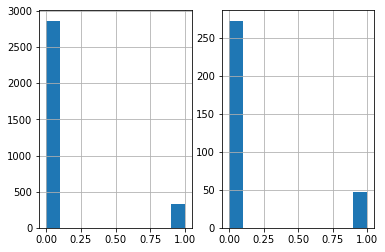

In [82]:
fig, axs = plt.subplots(ncols=2)
df_train.toxic.hist(ax=axs[0])
df_valid.toxic.hist(ax=axs[1])

### Handling class imbalance

In [83]:
from utils import upsample_class_imbalance

In [84]:
df_train_balanced = upsample_class_imbalance(df_train, 'toxic')
df_valid_balanced = upsample_class_imbalance(df_valid, 'toxic')

In [85]:
print('Train Data: Original ratio {} to {}'.format(*df_train.toxic.value_counts()))
print('Train Data: Rebalanced ratio {} to {}'.format(*df_train_balanced.toxic.value_counts()))
print('==')
print('Valid Data: Original ratio {} to {}'.format(*df_valid.toxic.value_counts()))
print('Valid Data: Rebalanced ratio {} to {}'.format(*df_valid_balanced.toxic.value_counts()))

Train Data: Original ratio 2868 to 332
Train Data: Rebalanced ratio 2868 to 2868
==
Valid Data: Original ratio 273 to 47
Valid Data: Rebalanced ratio 273 to 273


## Dataset

In [126]:
import dataset

In [127]:
df_train = df_train_balanced.copy()
df_valid = df_valid_balanced.copy()

In [128]:
print('Train: ', df_train.shape)
print('Valid: ', df_valid.shape)

Train:  (5736, 2)
Valid:  (546, 2)


In [129]:
train_dataset = dataset.BERTDataset(
    comment=df_train.comment_text.values,
    target=df_train.toxic.values
)

In [130]:
valid_dataset = dataset.BERTDataset(
    comment=df_valid.comment_text.values,
    target=df_valid.toxic.values
)

## Dataloaders

In [131]:
drop_last=False
train_sampler, valid_sampler = None, None

In [132]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=config.TRAIN_BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=drop_last,
    sampler=train_sampler
)

In [133]:
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=drop_last,
    sampler=valid_sampler
)

## Model

In [154]:
from utils import count_parameters
from model import BERTBaseUncased
from model import DistilBERTBaseCased

In [155]:
bert = BERTBaseUncased()
distil_bert = DistilBERTBaseCased()

In [156]:
print(f'Total parameters = {round(count_parameters(bert)*1e-6,2)}M')
print(f'Total parameters = {round(count_parameters(distil_bert)*1e-6,2)}M')

Total parameters = 167.36M
Total parameters = 134.74M


In [157]:
if config.MODEL == 'bert':
    model = bert
elif config.MODEL == 'distil-bert':
    model = distil_bert
else:
    print('Model chosen in config not valid')
    exit()
    
model.to(device) 

DistilBERTBaseCased(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

## Training

In [158]:
print(config.EPOCHS)

5


In [159]:
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing

from train import train_fn, eval_fn
from utils import print_current_config, Results

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data.distributed import DistributedSampler

### Training Config

In [160]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = config.LR
num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
# TODO: why do the LR increases because of a distributed training ?

if config.TPUs:
    num_train_steps /= n_TPUs
    lr *= n_TPUs

In [161]:
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(optimizer_parameters, lr=lr)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

if not config.TPUs:
    if N_GPU > 1:
        model = nn.DataParallel(model)

### Training Loop
mask = torch.Size([64, 128])

In [162]:
best_score = 0
results = Results()

for epoch in range(config.EPOCHS):

    start = time.time()

    if config.TPUs:
        train_loader = pl.ParallelLoader(train_data_loader, [device])
        valid_loader = pl.ParallelLoader(valid_data_loader, [device])
        tr_loss, tr_accy = train_fn(train_loader.per_device_loader(device), model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_loader.per_device_loader(device), model, device)

    else:
        tr_loss, tr_accy = train_fn(train_data_loader, model, optimizer, criterion, device, scheduler)
        va_loss, va_accy, (outputs, targets) = eval_fn(valid_data_loader, model, criterion, device)

    targets = np.array(targets) >= 0.5 ## TODO: Evaluate different THRESHOLDs ?
    auc_score = metrics.roc_auc_score(targets, outputs)

    delta = time.time() - start
    results.train_loss.append(tr_loss)
    results.train_accy.append(tr_accy)
    results.valid_loss.append(va_loss)
    results.valid_accy.append(va_accy)
    results.auc_score.append(auc_score)

    # Save if best
    print(f"AUC Score = {auc_score}")
    if auc_score > best_score:
        if not config.TPUs:
            torch.save(model.state_dict(), config.MODEL_PATH[config.MODEL])
        else:
            xm.save(model.state_dict(), config.MODEL_PATH[config.MODEL])
        best_score = auc_score







  0%|          | 0/90 [00:00<?, ?it/s]

torch.Size([64, 128])


  0%|          | 0/90 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 15.90 GiB total capacity; 15.03 GiB already allocated; 61.88 MiB free; 15.19 GiB reserved in total by PyTorch)

# Performance

## Loss  

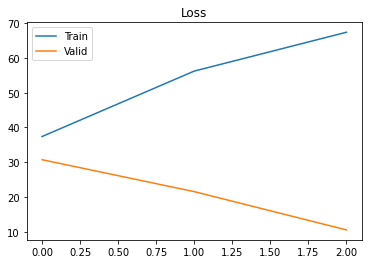

In [77]:
pd.DataFrame(
    data=np.array([results.train_loss, results.valid_loss]).T,
    columns=['Train', 'Valid']).plot(title='Loss')

## Accy

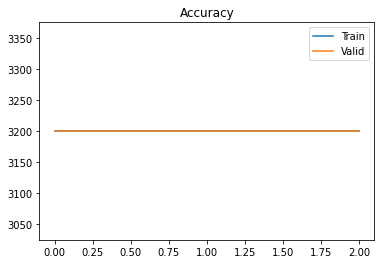

In [78]:
pd.DataFrame(
    data=np.array([results.train_accy, results.valid_accy]).T,
    columns=['Train', 'Valid']).plot(title='Accuracy')

## AUC

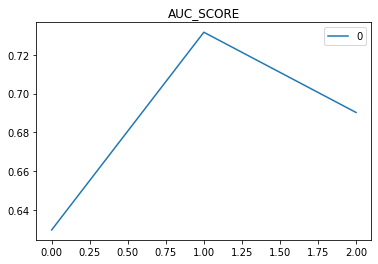

In [79]:
pd.DataFrame(data=np.array([results.auc_score]).T).plot(title='AUC_SCORE')